In [1]:
#print current working directory
import os
import sys
import pandas as pd
import numpy as np
import time
import torch
from torchvision import transforms
from torch.utils.data import DataLoader, WeightedRandomSampler
import matplotlib.pyplot as plt
from automl.automl import AutoML
from automl.datasets import FashionDataset, FlowersDataset, EmotionsDataset
from automl.utils import calculate_mean_std
sys.path.append(os.getcwd() + '/src')

In [ ]:
datasets = ["emotions", "fashion", "flowers"]
#print the classes of the datasets
for dataset in datasets:
    with open(f"data/{dataset}/train.csv") as f:
        train = pd.read_csv(f)
        #print "label" column unique values in ascending order
        print(f"Dataset {dataset} classes: ", sorted(train["label"].unique()))


Time to calculate mean and std for <class 'automl.datasets.EmotionsDataset'>: 0.0
torch.Size([64, 1, 48, 48])
torch.Size([64, 3, 48, 48])


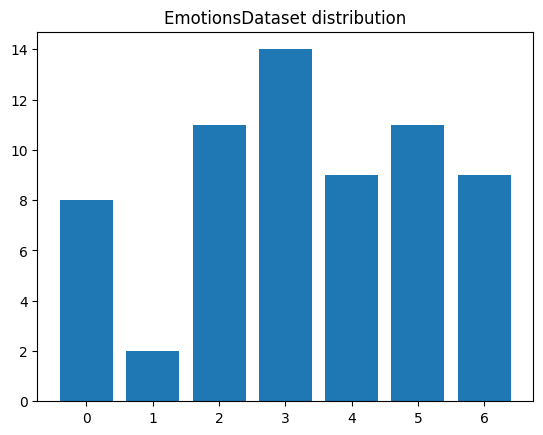

torch.Size([64, 1, 48, 48])
torch.Size([64, 3, 48, 48])


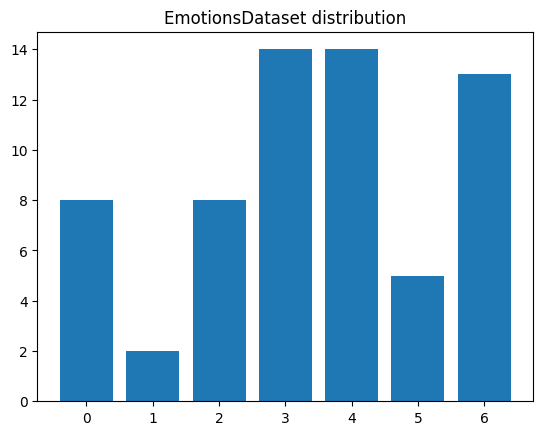

torch.Size([64, 1, 48, 48])
torch.Size([64, 3, 48, 48])


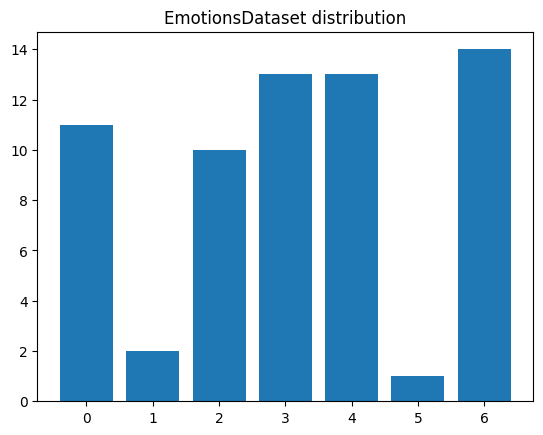

torch.Size([64, 1, 48, 48])
torch.Size([64, 3, 48, 48])


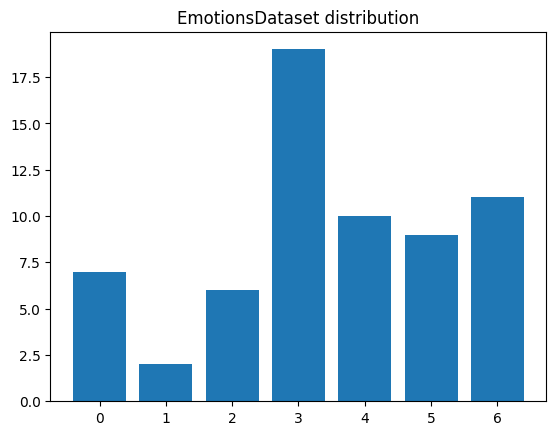

torch.Size([64, 1, 48, 48])
torch.Size([64, 3, 48, 48])


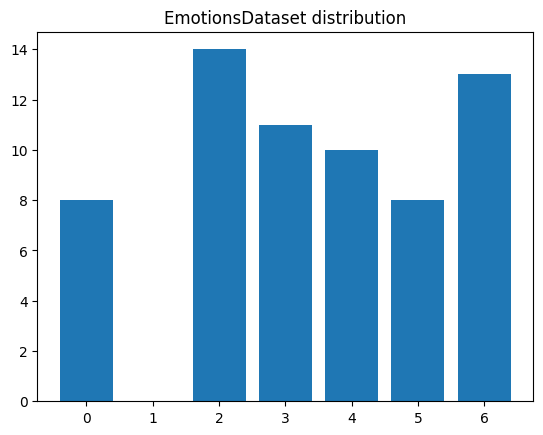

torch.Size([64, 1, 48, 48])
torch.Size([64, 3, 48, 48])


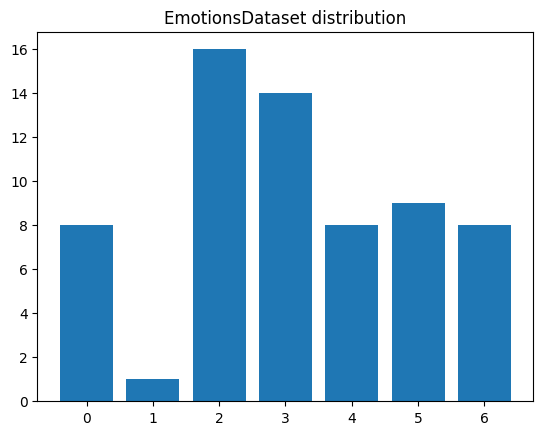

torch.Size([64, 1, 48, 48])
torch.Size([64, 3, 48, 48])


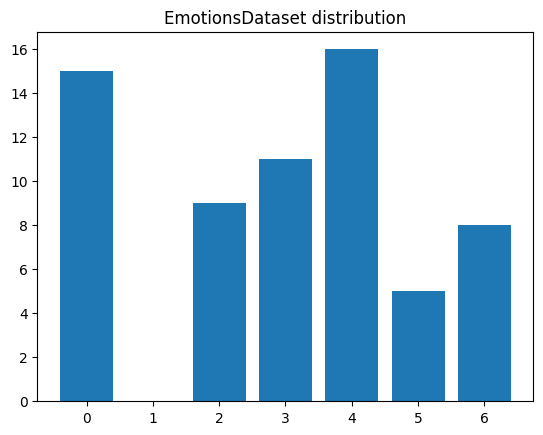

KeyboardInterrupt: 

In [3]:
datasets = {"emotions": EmotionsDataset}
#Create an object for each dataset
for ds_file, ds_class in datasets.items():
    #start a timer
    start = time.time()
    tr = transforms.Compose(
            [
                transforms.ToTensor(),
                # transforms.Normalize(*calculate_mean_std(ds_class)),
            ]
        )
    end = time.time()
    print(f"Time to calculate mean and std for {ds_class}: {end-start}")

    ds = ds_class(
        root="./data",
        split='train',
        download=True,
        transform=tr
    )
    dataloader = DataLoader(ds, batch_size=64, shuffle=True)
    for idx, (x,y) in enumerate(dataloader):
        print(x.shape)
        data = torch.cat((x, x, x), 1)
        print(data.shape)
        unique, counts = np.unique(y.numpy(), return_counts=True)
        #plot the distribution of the classes
        plt.bar(unique, counts)
        plt.title(f"{ds_class.__name__} distribution")
        plt.show()


In [ ]:
datasets = {"emotions": EmotionsDataset, "fashion": FashionDataset, "flowers": FlowersDataset}
#Create an object for each dataset
for ds_file, ds_class in datasets.items():
    print(type(ds_class))
    #start a timer
    start = time.time()
    tr = transforms.Compose(
            [
                transforms.ToTensor(),
                # transforms.Normalize(*calculate_mean_std(ds_class)),
            ]
        )
    end = time.time()
    print(f"Time to calculate mean and std for {ds_class}: {end-start}")

    ds = ds_class(
        root="./data",
        split='train',
        download=True,
        transform=tr
    )

    with open(f"data/{ds_file}/train.csv") as f:
        train = pd.read_csv(f)
    _, counts = np.unique(train["label"], return_counts=True)
    class_weights = 1.0/counts
    sample_weights = [class_weights[label] for label in train["label"]]
    sampler = WeightedRandomSampler(sample_weights, len(sample_weights))
    
    dataloader = DataLoader(ds, batch_size=64, sampler=sampler)
    for idx, (x,y) in enumerate(dataloader):
        unique, counts = np.unique(y.numpy(), return_counts=True)
        #plot the distribution of the classes
        plt.bar(unique, counts)
        plt.title(f"{ds_class.__name__} distribution")
        plt.show()


In [8]:
import torch
import torch.nn as nn

from torchvision import models


class ModifiedResNetBase(nn.Module):

    def __init__(self):
        super().__init__()
        # Load ResNet model pretrained on ImageNet data
        self.resnet = models.efficientnet_b1(pretrained=True)

    def disable_gradients(self, model) -> None:
        """
        Freezes the layers of a model
        Args:
            model: The model with the layers to freeze
        Returns:
            None
        """
        # START TODO #############
        # Iterate over model parameters and disable requires_grad
        # This is how we "freeze" these layers (their weights do not change during training)
        for param in model.parameters():
            param.requires_grad = False
        # END TODO #############

    def forward(self, x) -> torch.Tensor:
        # START TODO #############
        return self.resnet(x)
        # END TODO #############

In [9]:
class ModifiedResNet2(ModifiedResNetBase):
    def __init__(self):
        super().__init__()
        # START TODO #############
        # Create a new linear layer with 10 outputs
        # Replace the linear of resnet with this new layer - this is the only layer we shall train
        # Thus, freeze the other resnet layers by calling disable_gradient. See the model printout for
        # more information
        self.disable_gradients(self.resnet)
        self.resnet.fc = nn.Linear(512, 10)
        # END TODO #############

In [10]:
resnet2 = ModifiedResNet2()
print(resnet2)

c:\Users\Settings\miniconda3\envs\automl-vision-env\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Settings\miniconda3\envs\automl-vision-env\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B1_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B1_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ModifiedResNet2(
  (resnet): EfficientNet(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): SiLU(inplace=True)
      )
      (1): Sequential(
        (0): MBConv(
          (block): Sequential(
            (0): Conv2dNormActivation(
              (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
              (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (2): SiLU(inplace=True)
            )
            (1): SqueezeExcitation(
              (avgpool): AdaptiveAvgPool2d(output_size=1)
              (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
              (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
              (activation): SiLU(inplace=True)
              (scal